In [1]:
import numpy as np
import matplotlib.pylab as plt
import tensorflow as tf
import cv2
import tensorflow_hub as hub
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow_datasets as tfds
import os

In [2]:
current_dir = '/content/drive/MyDrive/Colab Notebooks/dataset/RockPaperScissors'
train_dir = os.path.join(current_dir, 'train')
test_dir = os.path.join(current_dir, 'test')
val_dir = os.path.join(current_dir, 'validation')

In [3]:
from google.colab.patches import cv2_imshow
def displayImages(images):
  for i in images:
    cv2_imshow(i)

In [4]:
def grayScaleImages(directory):
  imageArray = []
  labelArray = []
  for item in os.listdir(directory): #assuming gif
    current_dir=os.path.join(directory,item)
    for item1 in os.listdir(current_dir):
      image = cv2.imread(os.path.join(current_dir,item1))
      image = cv2.resize(image, (224,224))
      gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
      blurred = cv2.GaussianBlur(gray, (3,3), 0)
      edged = cv2.Canny(blurred, 30, 200)
      imageArray.append(edged)
      if item == "paper":
        label = 0
      elif item == "rock":
        label = 1
      else:
        label = 2
      labelArray.append(label)
  return np.array(imageArray), np.array(labelArray)
      
train_images, train_labels = grayScaleImages(train_dir)
val_images, val_labels = grayScaleImages(val_dir)
test_images, test_labels =grayScaleImages(test_dir)

In [5]:
#run only once
train_images = np.expand_dims(train_images, -1)
val_images = np.expand_dims(val_images, -1)
test_images = np.expand_dims(test_images, -1)

In [6]:
#np.random.shuffle(train_images)
#np.random.shuffle(val_images)
#np.random.shuffle(test_images)

print("Training set length:",len(train_images))
print("Validation set length:",len(val_images))
print("Test set length:",len(test_images))

print("Training set shape:",train_images.shape)
print("Validation set shape:",val_images.shape)
print("Test set shape:",test_images.shape)

print("Training set shape (label):",type(train_labels[0]))

Training set length: 2520
Validation set length: 33
Test set length: 372
Training set shape: (2520, 224, 224, 1)
Validation set shape: (33, 224, 224, 1)
Test set shape: (372, 224, 224, 1)
Training set shape (label): <class 'numpy.int64'>


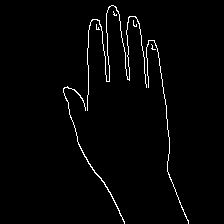

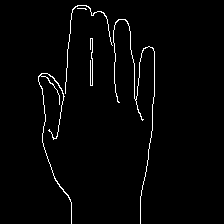

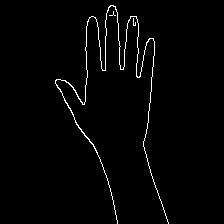

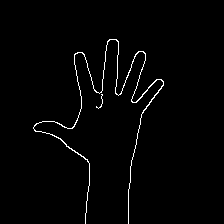

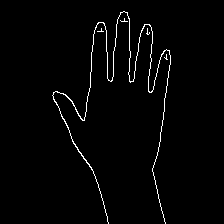

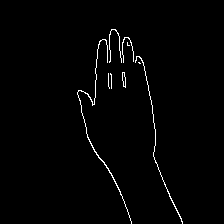

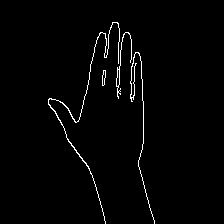

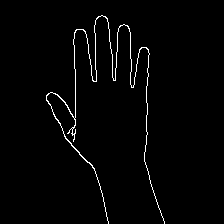

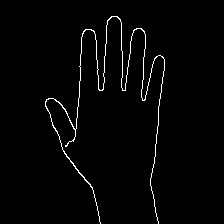

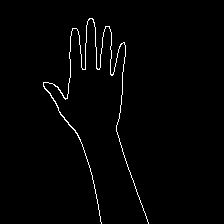

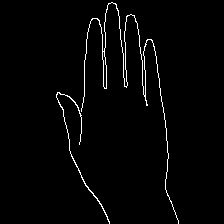

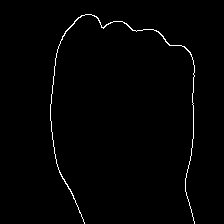

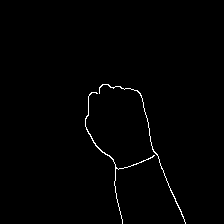

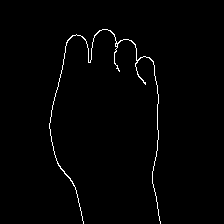

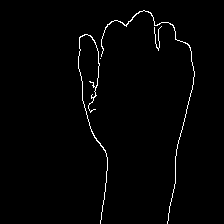

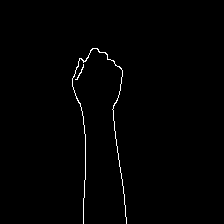

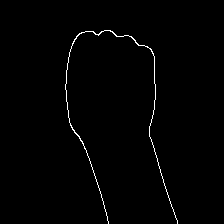

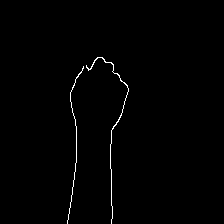

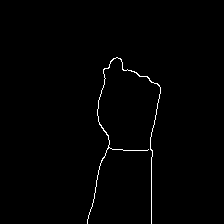

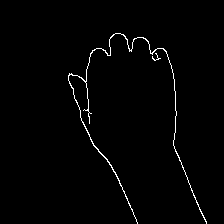

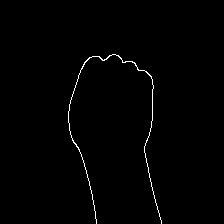

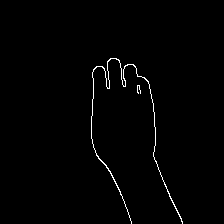

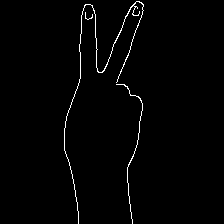

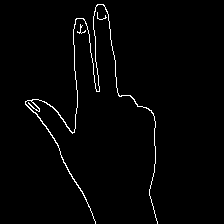

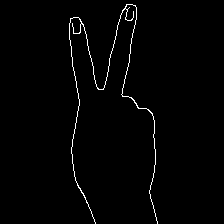

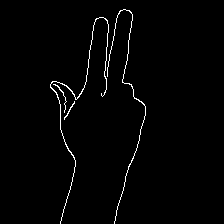

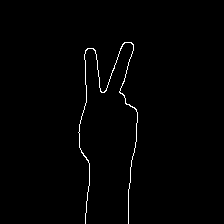

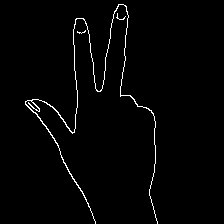

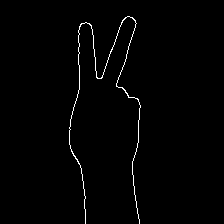

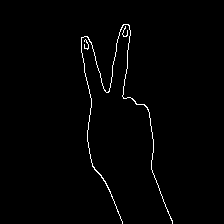

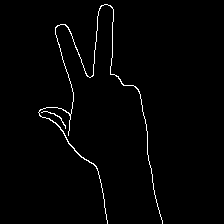

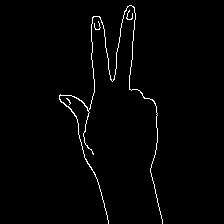

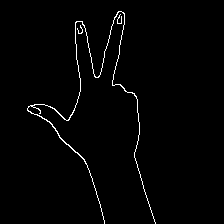

[0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2]


In [7]:
displayImages(val_images)
print(val_labels)

In [8]:
batch_size = 32
IMG_SHAPE = train_images[0].shape

In [9]:
image_gen_train = ImageDataGenerator(#rescale=1. / 255,
                                         #rotation_range=45,
                                         #zoom_range=.5,
                                         #horizontal_flip=True,
                                         #vertical_flip=True,
                                         #brightness_range=(.25, .5),
                                         #width_shift_range=.15,
                                         #height_shift_range=.15
                                         )
train_data_gen = image_gen_train.flow(batch_size=batch_size, x=train_images,y=train_labels, shuffle=True)

image_gen_val = ImageDataGenerator()#rescale=1. / 255)
val_data_gen = image_gen_val.flow(batch_size=batch_size, x=val_images,y=val_labels, shuffle=True)

image_gen_test = ImageDataGenerator()#rescale=1. / 255)
test_data_gen = image_gen_test.flow(batch_size=batch_size, x=test_images,y=test_labels, shuffle=True)

0


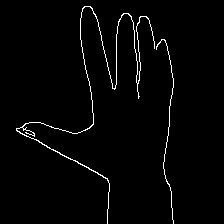

In [10]:
#(image, label) = train_data_gen
print(train_data_gen[0][1][0])
cv2_imshow(train_data_gen[0][0][0])

In [11]:
model = tf.keras.models.Sequential([
    # First convolution.
    tf.keras.layers.Convolution2D(input_shape=(224,224,1),filters=64,kernel_size=3,activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2),strides=(2, 2)),
    # Second convolution.
    #tf.keras.layers.Convolution2D(filters=64,kernel_size=3,activation='relu'),
    #tf.keras.layers.MaxPooling2D(pool_size=(2, 2),strides=(2, 2)),
    # Third convolution.
    #tf.keras.layers.Convolution2D(filters=128,kernel_size=3,activation='relu'),
    #tf.keras.layers.MaxPooling2D(pool_size=(2, 2),strides=(2, 2)),
    # Fourth convolution.
    #tf.keras.layers.Convolution2D(filters=128,kernel_size=3,activation='relu'),
    #tf.keras.layers.MaxPooling2D(pool_size=(2, 2),strides=(2, 2)),
    # Flatten the results to feed into dense layers.
    tf.keras.layers.Flatten(),
    #tf.keras.layers.Dropout(0.5),
    # 512 neuron dense layer.
    tf.keras.layers.Dense(units=512,activation='relu'),
    tf.keras.layers.Dense(units=512,activation='relu'),
    # Output layer.
    tf.keras.layers.Dense(units=3)
])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 64)      640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 64)     0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 788544)            0         
                                                                 
 dense (Dense)               (None, 512)               403735040 
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 dense_2 (Dense)             (None, 3)                 1539      
                                                        

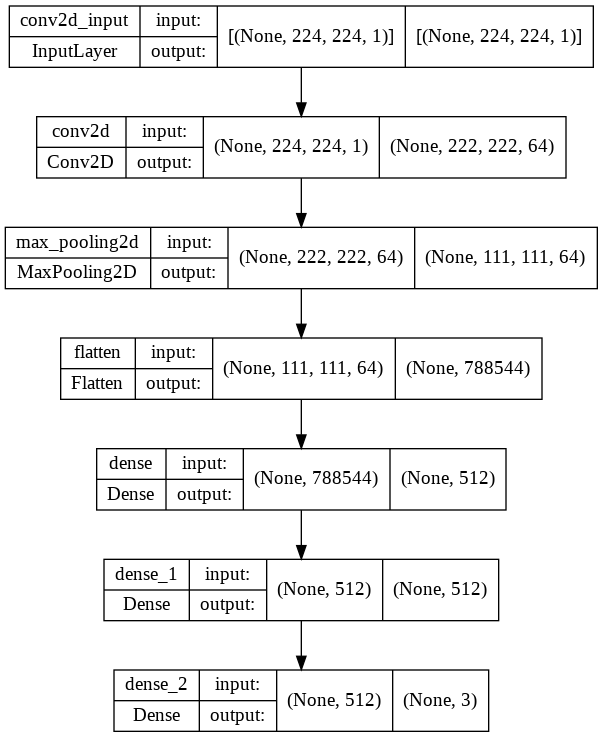

In [12]:
model.summary()
tf.keras.utils.plot_model(model,show_shapes=True,show_layer_names=True)

In [13]:
# adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
#rmsprop_optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)

model.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(),metrics=['accuracy'])

In [14]:
steps_per_epoch = len(train_images) // batch_size - 1
validation_steps = len(test_images) // batch_size
hist = model.fit(
    x=train_data_gen,
    validation_data=test_data_gen,
    epochs=1,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps
)

77/77 [==============================] - 451s 6s/step - loss: 1.1783 - accuracy: 0.3278 - val_loss: 1.0986 - val_accuracy: 0.3608


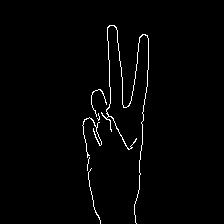

(224, 224)
(1, 224, 224, 1)
[[ -8412.929   -5734.2803 -10258.474 ]]
1


In [18]:
testCV2 = '/content/drive/MyDrive/Colab Notebooks/dataset/testCV@/frame0.jpg'
image = cv2.imread(testCV2)
cv2_imshow(image)
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
print(image.shape)
image = np.expand_dims(image, 0)
image = np.expand_dims(image, -1)
print(image.shape)
predictions = model.predict(image)
print(predictions)
print(np.argmax(predictions))